# MNIST Image Classification with TensorFlow on Cloud ML Engine

This notebook demonstrates how to implement different image models on MNIST using Estimator. 

Note the MODEL_TYPE; change it to try out different models

In [4]:
import os
PROJECT = 'cloud-training-demos' # REPLACE WITH YOUR PROJECT ID
BUCKET = 'cloud-training-demos-ml' # REPLACE WITH YOUR BUCKET NAME
REGION = 'us-central1' # REPLACE WITH YOUR BUCKET REGION e.g. us-central1
MODEL_TYPE='cnn'  # 'linear', 'dnn', 'dnn_dropout', or 'cnn'

# do not change these
os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['MODEL_TYPE'] = MODEL_TYPE
os.environ['TFVERSION'] = '1.8'  # Tensorflow version

In [5]:
import os
output = os.popen("gcloud config get-value project").readlines()
project_name = output[0][:-1]

# change these to try this notebook out
PROJECT = project_name
BUCKET = project_name
#BUCKET = BUCKET.replace("qwiklabs-gcp-", "inna-bckt-")
REGION = 'europe-west1'  ## note: Cloud ML Engine not availabe in europe-west3!

# set environment variables:
os.environ['BUCKET'] = BUCKET
os.environ['PROJECT'] = PROJECT
os.environ['REGION'] = REGION

print(PROJECT)
print(BUCKET)
print("gsutil mb -l {0} gs://{1}".format(REGION, BUCKET))

## set config for gcp config: [[?]]
print(os.popen("gcloud config set project $PROJECT").readlines())
print(os.popen("gcloud config set compute/region $REGION").readlines())

qwiklabs-gcp-d1510d1177dc7fc8
qwiklabs-gcp-d1510d1177dc7fc8
gsutil mb -l europe-west1 gs://qwiklabs-gcp-d1510d1177dc7fc8
[]
[]


In [6]:
%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


## Run as a Python module

In the previous notebook (mnist_linear.ipynb) we ran our code directly from the notebook.

Now since we want to run our code on Cloud ML Engine, we've packaged it as a python module.

The `model.py` and `task.py` containing the model code is in <a href="mnistmodel/trainer">mnistmodel/trainer</a>

**Complete the TODOs in `model.py` before proceeding!**

Once you've completed the TODOs, set MODEL_TYPE and run it locally for a few steps to test the code.

In [7]:
!echo $MODEL_TYPE

cnn


In [8]:
%bash
rm -rf mnistmodel.tar.gz mnist_trained
gcloud ml-engine local train \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   -- \
   --output_dir=${PWD}/mnist_trained \
   --train_steps=100 \
   --learning_rate=0.01 \
   --model=$MODEL_TYPE

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz


/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.data to implement this functionality.
Instructions for updating:
Please use tf.one_hot on tensors.
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
INFO:tensorflow:TF_CONFIG environment variable: {'environment': 'cloud', 'job': {'job_name': 'trainer.task', 'arg

**Now, let's do it on Cloud ML Engine so we can train on GPU:** `--scale-tier=BASIC_GPU`

Note the GPU speed up depends on the model type. You'll notice the more complex CNN model trains significantly faster on GPU, however the speed up on the simpler models is not as pronounced.

In [9]:
%bash
OUTDIR=gs://${BUCKET}/mnist/trained_${MODEL_TYPE}
JOBNAME=mnist_${MODEL_TYPE}_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=trainer.task \
   --package-path=${PWD}/mnistmodel/trainer \
   --job-dir=$OUTDIR \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC_GPU \
   --runtime-version=$TFVERSION \
   -- \
   --output_dir=$OUTDIR \
   --train_steps=10000 --learning_rate=0.01 --train_batch_size=512 \
   --model=$MODEL_TYPE --batch_norm

gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn europe-west1 mnist_cnn_190222_080759
jobId: mnist_cnn_190222_080759
state: QUEUED


CommandException: 1 files/objects could not be removed.
Job [mnist_cnn_190222_080759] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ml-engine jobs describe mnist_cnn_190222_080759

or continue streaming the logs with the command

  $ gcloud ml-engine jobs stream-logs mnist_cnn_190222_080759


## Monitoring training with TensorBoard

Use this cell to launch tensorboard

In [10]:
from google.datalab.ml import TensorBoard
TensorBoard().start('gs://{}/mnist/trained_{}'.format(BUCKET, MODEL_TYPE))

/usr/local/envs/py3env/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


TensorBoard was started successfully with pid 4000. Click here to access it.

4000

In [11]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

Stopped TensorBoard with pid 4000


#### Some of the Logs for CNN model

(Rather at the end, only selected lines)

```
global_step/sec: 139.711
loss = 0.017031638, step = 9900 (0.716 sec)
Saving checkpoints for 10000 into gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/model.ckpt.
Starting evaluation at 2019-02-22-08:13:20
Restoring parameters from gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/model.ckpt-10000
Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10764 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7)
Finished evaluation at 2019-02-22-08:13:22
Saving dict for global step 10000: accuracy = 0.9836, global_step = 10000, loss = 0.08720327
Signatures INCLUDED in export for Classify: None
Signatures INCLUDED in export for Regress: None
Signatures INCLUDED in export for Predict: ['serving_default', 'classes']
Adding visible gpu devices: 0
Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 10764 MB memory) -> physical GPU (device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7)
Restoring parameters from gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/model.ckpt-10000
Assets added to graph.
No assets to write.
SavedModel written to: gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/export/exporter/temp-1550823202/saved_model.pb
Loss for final step: 0.086979106.
```

Here are my results:

```
Model | Accuracy | Time taken | Model description | Run time parameters
--- | :---: | ---
linear | 91.53 | 3 min | linear | 100 steps, LR=0.01, Batch=512
linear | 92.73 | 8 min | linear | 1000 steps, LR=0.01, Batch=512
linear | 92.29 | 18 min | linear | 10000 steps, LR=0.01, Batch=512
dnn | 98.14 | 15 min | 300-100-30 nodes fully connected | 10000 steps, LR=0.01, Batch=512
dnn | 97.99 | 48 min | 300-100-30 nodes fully connected | 100000 steps, LR=0.01, Batch=512
dnn_dropout | 97.84 | 29 min | 300-100-30-DL(0.1)- nodes | 20000 steps, LR=0.01, Batch=512
cnn | 98.97 | 35 min | maxpool(10 5x5 cnn, 2)-maxpool(20 5x5 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 98.93 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25) | 20000 steps, LR=0.01, Batch=512
cnn | 99.17 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits only) | 20000 steps, LR=0.01, Batch=512
cnn | 99.27 | 35 min | maxpool(10 11x11 cnn, 2)-maxpool(20 3x3 cnn, 2)-300-DL(0.25), batch_norm (logits, deep) | 10000 steps, LR=0.01, Batch=512
cnn | 99.48 | 12 hr | as-above but nfil1=20, nfil2=27, dprob=0.1, lr=0.001, batchsize=233 | (hyperparameter optimization)
```

Create a table to keep track of your own results as you experiment with model type and hyperparameters!

From logs in Cloud ML GCP Page:

```
| Model            | Loss for final step |
| ---------------- | -----------------  |
| DNN              | 0.0024385566        |
| DNN with dropout | 0.08717914          | Saving dict for global step 10000: accuracy = 0.9714, global_step = 10000, loss = 0.19375572
| CNN              | 0.086979106         | Saving dict for global step 10000: accuracy = 0.9836, global_step = 10000, loss = 0.08720327
```

## Deploying and predicting with model

Deploy the model:

In [13]:
%bash
MODEL_NAME="mnist"
MODEL_VERSION=${MODEL_TYPE}
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/mnist/trained_${MODEL_TYPE}/export/exporter | tail -1)
echo "Deleting and deploying $MODEL_NAME $MODEL_VERSION from $MODEL_LOCATION ... this will take a few minutes"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version=$TFVERSION

Deleting and deploying mnist cnn from gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/export/exporter/1550823202/ ... this will take a few minutes


ERROR: (gcloud.ml-engine.models.create) Resource in project [qwiklabs-gcp-d1510d1177dc7fc8] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
ERROR: (gcloud.ml-engine.versions.create) ALREADY_EXISTS: Field: version.name Error: A version with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A version with the same name already exists.
    field: version.name


To predict with the model, let's take one of the example images.

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting mnist/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting mnist/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting mnist/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py fr

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


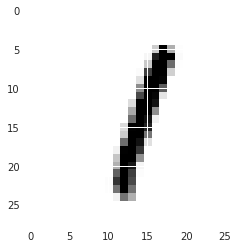

In [14]:
import json, codecs
import matplotlib.pyplot as plt
from tensorflow.examples.tutorials.mnist import input_data

HEIGHT=28
WIDTH=28

mnist = input_data.read_data_sets('mnist/data', one_hot=True, reshape=False)
IMGNO=5 #CHANGE THIS to get different images
jsondata = {'image': mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH).tolist()}
json.dump(jsondata, codecs.open('test.json', 'w', encoding='utf-8'))
plt.imshow(mnist.test.images[IMGNO].reshape(HEIGHT, WIDTH));

Prediction with DNN with dropout:
```
CLASSES  PROBABILITIES
1        [6.296275000631441e-30, 1.0, 1.8646024367974916e-28, 6.413484539171141e-29, 6.740793685627217e-20, 8.823438499032172e-27, 3.183225285434738e-36, 2.819988924516263e-20, 2.6393468285896378e-15, 3.232898161415615e-13]
```

Send it to the prediction service

In [15]:
%bash
gcloud ml-engine predict \
   --model=mnist \
   --version=${MODEL_TYPE} \
   --json-instances=./test.json

CLASSES  PROBABILITIES
1        [1.5641251023849324e-30, 1.0, 6.316736522120792e-26, 0.0, 9.330423633981259e-22, 1.630922713149645e-25, 3.4916248038090473e-28, 1.8372297000545262e-27, 1.0361169061632659e-16, 4.647386317162386e-29]


In [16]:
%bash
## download model to local file system:

## not:
##inna-bckt-120695964d64ec72/mnist_dnn_dropout_190221_141035/9cf3b9b97d342bdc3693fa2db71bb3f23181dcebbe3abca3cb67b16374b7bcb8
#gsutil cp -r gs://$BUCKET/mnist_dnn_dropout_190221_141035/9cf3b9b97d342bdc3693fa2db71bb3f23181dcebbe3abca3cb67b16374b7bcb8/* .

# ## download DNN, hard-coded directory:
# ##inna-bckt-120695964d64ec72/mnist/trained_dnn_dropout
# gsutil cp -r gs://$BUCKET/mnist/trained_dnn_dropout .

## download CNN:
gsutil cp -r gs://$BUCKET/mnist/trained_${MODEL_TYPE} .

Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/checkpoint...
Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/eval/events.out.tfevents.1550823090.cmle-training-13168643516927694946...
- [2 files][109.5 KiB/109.5 KiB]                                                
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m cp ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/events.out.tfevents.1550823062.cmle-training-13168643516927694946...
Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/export/exporter/1550823092/saved_model.pb...
Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/export/exporter/1550823092/variables/variables.data-00000-of-00001...
Copying gs://qwiklabs-gcp-d1510d1177dc7fc8/mnist/trained_cnn/export/exporter/1550823092/va

In [17]:
ls -l

total 124
-rw-r--r-- 1 root root 10305 Feb 22 07:48 flowers_fromscratch.ipynb
drwxr-xr-x 2 root root  4096 Feb 22 07:48 flowersmodel/
drwxr-xr-x 3 root root  4096 Feb 22 08:31 mnist/
-rw-r--r-- 1 root root 33824 Feb 22 07:48 mnist_linear.ipynb
drwxr-xr-x 5 root root  4096 Feb 22 08:08 mnistmodel/
-rw-r--r-- 1 root root 46507 Feb 22 08:32 mnist_models.ipynb
drwxr-xr-x 4 root root  4096 Feb 22 08:06 mnist_trained/
-rw-r--r-- 1 root root  5234 Feb 22 08:31 test.json
drwxr-xr-x 4 root root  4096 Feb 22 08:33 trained_cnn/


In [19]:
%bash
ls -l ./trained_${MODEL_TYPE}/export/exporter

total 8
drwxr-xr-x 3 root root 4096 Feb 22 08:33 1550823092
drwxr-xr-x 3 root root 4096 Feb 22 08:33 1550823202


In [20]:
## find lates model on local disk:
from pathlib import Path

export_dir = 'trained_cnn/export/exporter'
subdirs = [x for x in Path(export_dir).iterdir()
           if x.is_dir() and 'temp' not in str(x)]
latest = str(sorted(subdirs)[-1])

print(latest)

trained_cnn/export/exporter/1550823202


In [21]:
## load model from local disk and make predictions:
from tensorflow.contrib import predictor

predict_fn = predictor.from_saved_model(latest)

pred = predict_fn({'image': mnist.test.images[0:2, :, :, 0]})
print(pred)
print(pred['classes'])

INFO:tensorflow:Restoring parameters from b'trained_cnn/export/exporter/1550823202/variables/variables'
{'classes': array([7, 2], dtype=uint8), 'probabilities': array([[0.0000000e+00, 3.2878167e-30, 1.2056782e-30, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 5.3508532e-33],
       [0.0000000e+00, 6.6826002e-27, 1.0000000e+00, 6.7902008e-32,
        0.0000000e+00, 0.0000000e+00, 2.7345995e-38, 6.4616102e-31,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)}
[7 2]


In [22]:
## make pandas dataframe from predictions:
import pandas as pd
import numpy as np

pred = predict_fn({'image': mnist.test.images[:, :, :, 0]})['classes']

dat_pred = pd.DataFrame({'label': np.argmax(mnist.test.labels, axis = 1),
                         'pred' : pred})
dat_pred['correct'] = (dat_pred['label'] == dat_pred['pred'])
print(dat_pred.head(n = 5))


acc = dat_pred['correct'].mean()
print('Accuracy = ', acc)

print('\n')
print('Accuracy by label:')
print(dat_pred.groupby(['label'])[['correct']].mean())


   label  pred  correct
0      7     7     True
1      2     2     True
2      1     1     True
3      0     0     True
4      4     4     True
Accuracy =  0.9836


Accuracy by label:
        correct
label          
0      0.987755
1      0.991189
2      0.978682
3      0.995050
4      0.986762
5      0.968610
6      0.983299
7      0.989300
8      0.987680
9      0.965312


<pre>
# Copyright 2017 Google Inc. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
</pre>